In [1]:
from __future__ import division
from __future__ import print_function

import datetime
import json
import logging
import os
import pickle
import time
import wandb
from datetime import datetime
import numpy as np
import optimizers
import torch
from config import parser
from models.base_models import NCModel, LPModel
from utils.data_utils import load_data
from utils.train_utils import get_dir_name, format_metrics
from GroupedMLP import GroupedMLP
import matplotlib.pyplot as plt
# 获取当前工作目录
hgnc_home = os.getcwd()

# 设置环境变量,代替Linux的source set_env.sh命令
os.environ['HGCN_HOME'] = hgnc_home
os.environ['LOG_DIR'] = os.path.join(hgnc_home, 'logs')
os.environ['PYTHONPATH'] = f"{hgnc_home}:{os.environ.get('PYTHONPATH', '')}"
os.environ['DATAPATH'] = os.path.join(hgnc_home, 'data')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import sys
from config import parser  # 确保这是你正确的 `argparse` 的 `parser`
# python train.py --task nc --dataset disease_nc --model HGCN --dim 16 --lr 0.01 --num-layers 2 --act relu --bias 1 --dropout 0 --weight-decay 0 --manifold PoincareBall --log-freq 5 --cuda -1
# 检查是否在 Jupyter Notebook 环境中运行
def mytrain(epochs,manifold):
    if __name__ == '__main__':
        if 'ipykernel' in sys.modules:
            # 在 Jupyter 环境下，使用 `parse_known_args` 来忽略未知参数
            args, unknown = parser.parse_known_args()
        else:
            # 正常环境下
            args = parser.parse_args()#argparse模块是命令行选项、参数和子命令解析器。可以让人轻松编写用户友好的命令行接口。
        args.task='lp'
        args.dataset='cora'
        args.model='Shallow'#[Shallow, MLP,  HNN, GCN, GAT, HGCN]
        args.dim=16
        args.lr=0.01
        args.num_layers=0
        args.act=None
        args.bias=0
        args.use_feats = 0
        args.dropout=0.2
        args.weight_decay=0.0005
        args.manifold=manifold
        args.log_freq=5
        args.cuda=-1 #-1 for cpu training
        args.seed = 1234
        args.optimizer = 'RiemannianAdam'
        args.epochs = epochs
        train(args)

d:\anaconda3\envs\hgcnenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda3\envs\hgcnenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
d:\anaconda3\envs\hgcnenv\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
d:\anaconda3\envs\hgcnenv\l

### 任务2：距离公式总结与梯度计算

请创建一个表格，总结以下三种距离公式：

1. [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/abs/1705.08039)，NeurIPS 2017
2. [Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/abs/1806.03417)，ICML 2018
3. Lorentzian Distance Learning for Hyperbolic Representations，ICML 2019

对于每一个距离公式，假设距离记作 `d^H(x, y)`，请计算以下关于 `x` 的梯度公式：

$$
\frac{\partial d^H(x,y)}{\partial x}
$$

并与欧几里得距离的梯度公式进行比较：

$$
\frac{\partial d^E(x,y)}{\partial x}
$$

请深入 HGCN 的代码，重点查看 [shallow 模型](https://github.com/HazyResearch/hgcn/blob/master/models/encoders.py)。在实验中，分别使用 Poincaré 球模型和 Lorentz 模型，聚焦于链接预测任务，用上面提到的三种不同的距离公式进行实验，并运行三次实验，记录实验结果均值和方差。

#### 2.1 距离公式总结

基础公式：
$$
 \langle x, y \rangle=x_1y_1+...+x_ny_n=x^T y = y^T x
$$

$$
\| x \| = \sqrt{x^T x}
$$

$$
\| x - y \|^2 = (x - y)^T (x - y) = x^T x - 2 x^T y + y^T y = \| x \|^2 - 2 \langle x, y \rangle + \| y \|^2
$$

0. 欧氏空间
$$
d^E(x,y) = \| x - y \| = \sqrt{ (x - y)^T (x - y) }
$$

$$
\frac{\partial d^E(x,y)}{\partial x} = \frac{ x - y }{ \| x - y \| }
$$

1. Poincare's ball 

Poincare's ball 模型：$ P^d = \{x ∈ R^d : \|x\| < 1\}$

$$
d^P(x, y) = arc\cosh\left( 1 + \frac{2\, \| x - y \|^2}{\left(1 - \| x \|^2\right)\left(1 - \| y \|^2\right)} \right)
$$

$$
\frac{{\partial d^P(x, y)}}{{\partial x}} = \frac{{2\left( {\left( {y{^2} - 2\langle x,y\rangle  + 1} \right)x - \left( {1 - x{^2}} \right)y} \right)}}{{\left( {1 - x{^2}} \right)x - y\sqrt {1 - 2\langle x,y\rangle  + x{^2}y{^2}} }}
$$

2. Lorentzian distance

在论文《Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry，ICML 2018-Maximilian Nickel, Douwe Kiela》中，通过洛伦兹模型（Lorentz Model），也称为双曲面模型（Hyperboloid Model），将双曲空间描述为n+1维的Minkowski空间的一个双曲面；

在Minkowski空间中，其度规通过Lorentzian 内积 ⟨x,y⟩L表示​：这个内积在第一个分量上取负号，其余分量保持正号。它用于在 Minkowski 空间中测量“时间”和“空间”分量之间的关系。公式如下：

$$
{\left\langle {x,y} \right\rangle _L} =  - {x_0}{y_0} + \sum\limits_{i = 1}^n {{x_i}{y_i}} 
$$

1)距离公式为双曲面hyperboloid模型：$H^{d,\beta}=\{x=(x_0,...,x_d)∈ R^{d+1}:\|x\|^2_L =-\beta \} $

上式可以表示成，对于在双曲面hyperboloid上的点$x=[x_0,x_1,..,x_d]$，满足：
$$
x^2_0+x^2_1+..+x^2_d=-\beta=1/c
$$

2)双曲面hyperboloid模型的曲率c为$-1/\beta$

3)论文2中取的单位双曲面hyperboloid模型，$\beta=1, \|x\|^2_L = {\left\langle {x,x} \right\rangle _L}  =-1$ ，对应的两点 x 和 y 之间的距离通过 Lorentzian 内积计算：
$$
d^L(x, y) = \operatorname{arccosh}\left( -\langle x, y \rangle_L \right)
$$

$$
\frac{{\partial d^L(x, y)}}{{\partial x}} = \frac{ \left( y_0, \ - y_1, \ - y_2, \ \dots, \ - y_n \right) }{ \sqrt{ \left( - \langle x, y \rangle_L \right)^2 - 1 }}=\frac{-g_L(x)y}{ \sqrt{ \left( - \langle x, y \rangle_L \right)^2 - 1 }}
$$

其中，度规张量
$g_L(x) = \begin{bmatrix}
-1 &  &  &  \\\\
 & 1 &  &  \\\\
 &  & \ddots &  \\\\
 &  &  & 1 \\
\end{bmatrix}$



3. squared Lorentzian distance

论文3不考虑双曲面的曲率$\beta=1$，而是把曲率$\beta$作为一个可调整的参数，给出了平方Lorentzian距离公式：
$$
d_L^2\left( {x,y} \right) = \left\| {x - y} \right\|_L^2 =  - 2\beta  - 2{\left\langle {x,y} \right\rangle _L}
$$
对于模型的输出空间$F^d$与一般的双曲面hyperboloid空间$H^{d,\beta}$，存在如下映射函数：
$$
{g_\beta }\left( {\rm{f}} \right) = \sqrt {{{\left\| {\rm{f}} \right\|}^2} + \beta }  \in {H^{d,\beta }},\left( {{f_1},...,{f_d}} \right) \in {F^d}
$$
对应的距离公式为：

$$
d_L^2\left( {x,y} \right) = d_L^2\left( {{g_\beta }\left( {{{\rm{f}}_x}} \right),{g_\beta }\left( {{{\rm{f}}_y}} \right)} \right) = 2\beta  - 2{\left\langle {{g_\beta }\left( {{{\rm{f}}_x}} \right),{g_\beta }\left( {{{\rm{f}}_y}} \right)} \right\rangle _L} $$

$$ =  - 2\left[ {\beta  + \left\langle {{{\rm{f}}_x},{{\rm{f}}_y}} \right\rangle  - s_x s_y } \right]
$$
梯度公式：
$$
\frac{{\partial d_L^2(x, y)}}{{\partial x}} =  = 2 \left( \left( \dfrac{s_y}{s_x} \right) \mathbf{f}_x - \mathbf{f}_y \right)
$$
其中，$ 
s_x = \sqrt{\| \mathbf{f}_x \|^2 + \beta} 
$，$
s_y = \sqrt{\| \mathbf{f}_y \|^2 + \beta}
$

#### 2.2 公式表格
| **模型**                  | **距离公式**                                                                                                                                                                   | **梯度公式**                                                                                                                                                                                                                                       |
|:-------------------------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| **欧氏空间**              | $d^E(x,y) = \| x - y \| = \sqrt{ (x - y)^T (x - y) }$                                                                                                                        | $ \frac{\partial d^E(x,y)}{\partial x} = \frac{ x - y }{ \| x - y \| } $                                                                                                                                                                         |
| **Poincare's ball**       | $d^P(x, y) = \operatorname{arccosh}\left( 1 + \frac{2\, \| x - y \|^2}{\left(1 - \| x \|^2\right)\left(1 - \| y \|^2\right)} \right)$                                          | $ \frac{{\partial d^P(x, y)}}{{\partial x}} = \frac{{2\left( {\left( {y{^2} - 2\langle x,y\rangle  + 1} \right)x - \left( {1 - x{^2}} \right)y} \right)}}{{\left( {1 - x{^2}} \right)x - y\sqrt {1 - 2\langle x,y\rangle  + x{^2}y{^2}} }} $       |
| **Lorentzian Distance（$\beta=1$）**   | $d^L(x, y) = \operatorname{arccosh}\left( -\langle x, y \rangle_L \right)$ | $ \frac{{\partial d^L(x, y)}}{{\partial x}} = \frac{-g_L(x)y}{ \sqrt{ \left( - \langle x, y \rangle_L \right)^2 - 1 }} $|
| **Squared Lorentzian Distance** | $d_L^2\left( {x,y} \right) =  - 2\beta  - 2{\left\langle {x,y} \right\rangle _L} = - 2\left[ \beta + \langle \mathbf{f}_x, \mathbf{f}_y \rangle - s_x s_y \right]$ ，$x$和$y$位于双曲面上，坐标分量要满足约束条件 | $ \frac{{\partial d_L^2(x, y)}}{{\partial x}} = 2 \left( \left( \dfrac{s_y}{s_x} \right) \mathbf{f}_x - \mathbf{f}_y \right) $, 其中，$ s_x = \sqrt{\| \mathbf{f}_x \|^2 + \beta} $，$s_y = \sqrt{\| \mathbf{f}_y \|^2 + \beta} $                      |



#### 2.3 三种距离公式实验

In [2]:
def train(args):
    np.random.seed(args.seed)# 设置随机种子
    torch.manual_seed(args.seed)
    # 创建空列表以存储每个 epoch 的指标
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    test_loss, test_acc = None, None  # 用于存储最佳测试集损失和准确率
    if int(args.double_precision):
        torch.set_default_dtype(torch.float64)
    if int(args.cuda) >= 0:
        torch.cuda.manual_seed(args.seed)
    args.device = 'cuda:' + str(args.cuda) if int(args.cuda) >= 0 else 'cpu'
    args.patience = args.epochs if not args.patience else  int(args.patience)
    logging.getLogger().setLevel(logging.INFO)
    # 设置保存路径
    if args.save:
        if not args.save_dir:
            dt = datetime.datetime.now()
            date = f"{dt.year}_{dt.month}_{dt.day}"
            models_dir = os.path.join(os.environ['LOG_DIR'], args.task, date)
            save_dir = get_dir_name(models_dir)
        else:
            save_dir = args.save_dir
        logging.basicConfig(level=logging.INFO,
                            handlers=[
                                logging.FileHandler(os.path.join(save_dir, 'log.txt')),
                                logging.StreamHandler()
                            ])

    logging.info(f'Using: {args.device}')
    logging.info("Using seed {}.".format(args.seed))
    '''
    ######加载数据#####
    '''
    data = load_data(args, os.path.join(os.environ['DATAPATH'], args.dataset))#加载数据，#返回的数据包括：邻居矩阵、特征、标签、等等...
    args.n_nodes, args.feat_dim = data['features'].shape#调整模型中第一个线性层的输入维度。
    if args.task == 'nc':#nc，用这个测试
        Model = NCModel
        args.n_classes = int(data['labels'].max() + 1)
        logging.info(f'Num classes: {args.n_classes}')
    else:
        args.nb_false_edges = len(data['train_edges_false'])
        args.nb_edges = len(data['train_edges'])
        if args.task == 'lp':#lp，用这个测试
            Model = LPModel
        else:
            Model = RECModel
            # No validation for reconstruction task
            args.eval_freq = args.epochs + 1

    if not args.lr_reduce_freq:
        args.lr_reduce_freq = args.epochs

    # 定义模型和优化器
    model = Model(args)
    logging.info(str(model))
    optimizer = getattr(optimizers, args.optimizer)(params=model.parameters(), lr=args.lr,
                                                    weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=int(args.lr_reduce_freq),
        gamma=float(args.gamma)
    )
    tot_params = sum([np.prod(p.size()) for p in model.parameters()])
    logging.info(f"Total number of parameters: {tot_params}")
    if args.cuda is not None and int(args.cuda) >= 0 :
        os.environ['CUDA_VISIBLE_DEVICES'] = str(args.cuda)
        model = model.to(args.device)
        for x, val in data.items():
            if torch.is_tensor(data[x]):
                data[x] = data[x].to(args.device)
    # 开始训练
    t_total = time.time()
    counter = 0
    best_val_metrics = model.init_metric_dict()
    best_test_metrics = None
    best_emb = None
    for epoch in range(args.epochs):#开始训练
        t = time.time()
        model.train()
        optimizer.zero_grad()
        # 编码特征
        embeddings = model.encode(data['features'], data['adj_train_norm'])#归一化邻接矩阵，表示节点间的连接关系。
        train_metrics = model.compute_metrics(embeddings, data, 'train')
        ###绘图部分的代码
        train_loss = train_metrics['loss'].item()  # 获取损失值
        train_acc = train_metrics['roc']  # 假设 'acc' 是计算的准确性
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        # 反向传播和优化
        train_metrics['loss'].backward()
        if args.grad_clip is not None:
            max_norm = float(args.grad_clip)
            all_params = list(model.parameters())
            for param in all_params:
                torch.nn.utils.clip_grad_norm_(param, max_norm)
        optimizer.step()
        lr_scheduler.step()
        # 打印训练日志
        if (epoch + 1) % args.log_freq == 0:
            logging.info(" ".join(['Epoch: {:04d}'.format(epoch + 1),# 1. 显示当前的训练轮次
                                   'lr: {}'.format(lr_scheduler.get_lr()[0]),# 2. 显示当前的学习率
                                   format_metrics(train_metrics, 'train'),# 3. 显示训练过程中的各种指标
                                   'time: {:.4f}s'.format(time.time() - t)# 4. 显示一个epoch所耗时间
                                   ]))
         # 验证模型
        if (epoch + 1) % args.eval_freq == 0:
            model.eval()
            embeddings = model.encode(data['features'], data['adj_train_norm'])
            val_metrics = model.compute_metrics(embeddings, data, 'val')
            val_loss = val_metrics['loss'].item()  # 获取损失值
            val_acc = val_metrics['roc']  #  'roc' 计算的准确性
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if (epoch + 1) % args.log_freq == 0:
                logging.info(" ".join(['Epoch: {:04d}'.format(epoch + 1), format_metrics(val_metrics, 'val')]))
            # 记录最佳验证指标
            if model.has_improved(best_val_metrics, val_metrics):
                best_test_metrics = model.compute_metrics(embeddings, data, 'test')
                best_emb = embeddings.cpu()
                if args.save:
                    np.save(os.path.join(save_dir, 'embeddings.npy'), best_emb.detach().numpy())
                best_val_metrics = val_metrics
                counter = 0
            else:
                counter += 1
                if counter == args.patience and epoch > args.min_epochs:
                    logging.info("Early stopping")
                    break
    '''
    调试打印输出
    '''
    print('节点数量和特征维度：',[args.n_nodes, args.feat_dim])
    # 输出最终的测试集结果
    logging.info("Optimization Finished!")
    logging.info("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    if not best_test_metrics:
        model.eval()
        best_emb = model.encode(data['features'], data['adj_train_norm'])
        best_test_metrics = model.compute_metrics(best_emb, data, 'test')
    logging.info(" ".join(["Val set results:", format_metrics(best_val_metrics, 'val')]))
    logging.info(" ".join(["Test set results:", format_metrics(best_test_metrics, 'test')]))
    # 提取损失和准确性
    test_loss = best_test_metrics['loss'].item()
    test_acc = best_test_metrics['roc']
    # 绘制训练和验证的损失及准确性曲线
    plt.figure(figsize=(12, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # 绘制准确性曲线
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train AUC-ROC')
    plt.plot(val_accuracies, label='Val AUC-ROC')
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test AUC-ROC: {test_acc:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('AUC-ROC')
    plt.title('Training and Validation AUC-ROC')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # 保存模型
    if args.save:
        np.save(os.path.join(save_dir, 'embeddings.npy'), best_emb.cpu().detach().numpy())
        if hasattr(model.encoder, 'att_adj'):
            filename = os.path.join(save_dir, args.dataset + '_att_adj.p')
            pickle.dump(model.encoder.att_adj.cpu().to_dense(), open(filename, 'wb'))
            print('Dumped attention adj: ' + filename)

        json.dump(vars(args), open(os.path.join(save_dir, 'config.json'), 'w'))
        torch.save(model.state_dict(), os.path.join(save_dir, 'model.pth'))
        logging.info(f"Saved model in {save_dir}")

INFO:root:Using: cpu
INFO:root:Using seed 1234.
INFO:root:LPModel(
  (encoder): Shallow(
    (layers): Sequential()
  )
  (dc): FermiDiracDecoder()
)
INFO:root:Total number of parameters: 42640
d:\anaconda3\envs\hgcnenv\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
INFO:root:Epoch: 0005 lr: 0.01 train_loss: 2.2529 train_roc: 0.7518 train_ap: 0.7184 time: 0.0319s
INFO:root:Epoch: 0005 val_loss: 2.2524 val_roc: 0.6360 val_ap: 0.6291
INFO:root:Epoch: 0010 lr: 0.01 train_loss: 2.2492 train_roc: 0.8359 train_ap: 0.8130 time: 0.0329s
INFO:root:Epoch: 0010 val_loss: 2.2484 val_roc: 0.6215 val_ap: 0.6217
INFO:root:Epoch: 0015 lr: 0.01 train_loss: 2.2413 train_roc: 0.8794 train_ap: 0.8624 time: 0.0329s
INFO:root:Epoch: 0015 val_loss: 2.2402 val_roc: 0.6395 val_ap: 0.6325
INFO:root:Epoch: 0020 lr: 0.01 train_loss: 2.2278 train_roc: 0.8963 train_ap: 

节点数量和特征维度： [2665, 2666]


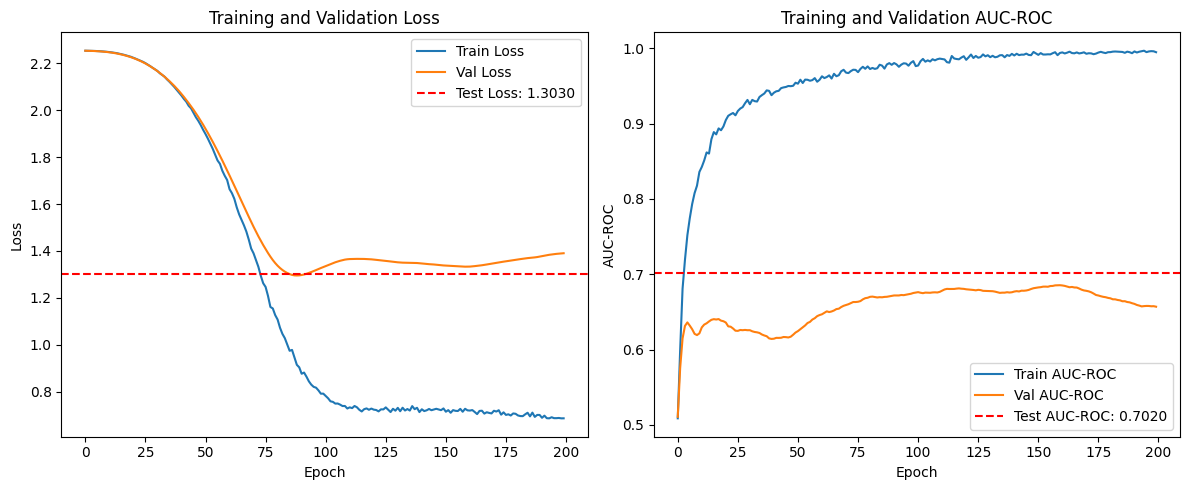

In [6]:
def mytrain(epochs,manifold,c):
    if __name__ == '__main__':
        if 'ipykernel' in sys.modules:
            # 在 Jupyter 环境下，使用 `parse_known_args` 来忽略未知参数
            args, unknown = parser.parse_known_args()
        else:
            # 正常环境下
            args = parser.parse_args()#argparse模块是命令行选项、参数和子命令解析器。可以让人轻松编写用户友好的命令行接口。
        args.task='lp'
        args.dataset='disease_lp' #[pubmed cora disease_lp airport]
        args.model='Shallow'#[Shallow, MLP,  HNN, GCN, GAT, HGCN]
        args.dim=16
        args.num_layers=0#shallow模型下，这个参数没用
        args.act=None
        args.bias=0
        args.use_feats = 0 #是否使用节点特征
        args.dropout=0.0
        args.lr=0.01
        args.weight_decay=0.0001
        args.manifold=manifold
        args.log_freq=5
        args.cuda=-1 #-1 for cpu training
        args.seed = 1234
        args.optimizer = 'RiemannianAdam' #[Adam, RiemannianAdam，RiemannianSGD]
        args.epochs = epochs
        args.c=c #不指定曲率c，c就是可训练参数
        train(args)
epochs = 200
manifold = 'Hyperboloid' #[Euclidean,论文3：Lorentz，论文2：Hyperboloid, 论文1：PoincareBall，测试用：Hyperboloidtest]
c=1.0#c在官网的定义为双曲面的半径/hyperbolic radius。但是当manifold = 'Hyperboloid'时，c表示双曲面的曲率curvature的绝对值
# c=1：论文1，2
mytrain(epochs,manifold,c)

### 任务3：阅读相关论文并集成代码

请重新阅读以下论文以及论文4：

1. [Hyperbolic Entailment Cones for Learning Hierarchical Embeddings](https://arxiv.org/abs/1804.01882)，ICML 2018
    
    Octavian-Eugen Ganea, Gary Bécigneul, Thomas Hofmann
    
2. [Hyperbolic Disk Embeddings for Directed Acyclic Graphs](https://arxiv.org/abs/1902.04335)，ICML 2019
    
    Ryota Suzuki, Ryusuke Takahama, Shun Onoda
    
3. [Modeling Heterogeneous Hierarchies with Relation-specific Hyperbolic Cones](https://arxiv.org/abs/2110.14923)，NeurIPS 2021
    
    Yushi Bai, Rex Ying, Hongyu Ren, Jure Leskovec
    
4. Inferring Concept Hierarchies from Text Corpora via Hyperbolic Embeddings, 这篇论文提到了Lorentz Cone
5. [Capacity and Bias of Learned Geometric Embeddings for Directed Graphs (Boratko et al. 2021)](https://proceedings.neurips.cc/paper/2021/hash/88d25099b103efd638163ecb40a55589-Abstract.html)

参考5的代码，把论文2、3、4的方法整理成和5中代码库相融合的方法，然后进行对比实验